In [1]:
import itertools
import json
import operator
import os
from pathlib import Path
from pprint import pprint
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

## Load data and preprocess

### Metadata

In [2]:
# Map from test suite tag to high-level circuit.
circuits = {
    "Licensing": ["npi", "reflexive"],
    "Long-Distance Dependencies": ["fgd", "embed", "number", "comparison"],
    "Garden-Path Effects": ["gardenpath", "npz", "mvrr"],
    "Gross Syntactic State": ["subordination", "nn"],
    "Center Embedding": ["center"],
    "Transformations": ["cleft"],
}

tag_to_circuit = {tag: circuit
                  for circuit, tags in circuits.items()
                  for tag in tags}

In [3]:
# Exclusions
exclude_suite_re = re.compile(r"^fgd-embed[34]|^npz_(ambig)|^gardenpath")

### Load

In [4]:
os.chdir("..")
ppl_data_path = Path("data/raw/perplexity.csv")
test_suite_results_path = Path("data/raw/test_suite_results")

In [5]:
perplexity_df = pd.read_csv(ppl_data_path, index_col=["model", "corpus", "seed"])
perplexity_df.index.set_names("model_name", level=0, inplace=True)

results_df = pd.concat([pd.read_csv(f) for f in test_suite_results_path.glob("*.csv")])

# Split model_id into constituent parts
model_ids = results_df.model.str.split("_", expand=True).rename(columns={0: "model_name", 1: "corpus", 2: "seed"})
results_df = pd.concat([results_df, model_ids], axis=1).drop(columns=["model"])
results_df["seed"] = results_df.seed.astype(int)

# Exclude test suites
exclude_filter = results_df.suite.str.contains(exclude_suite_re)
print("Dropping %i results / %i suites due to exclusions."
      % (exclude_filter.sum(), len(results_df[exclude_filter].suite.unique())))
results_df = results_df[~exclude_filter]

# Add tags
results_df["tag"] = results_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
results_df["circuit"] = results_df.tag.map(tag_to_circuit)
tags_missing_circuit = set(results_df.tag.unique()) - set(tag_to_circuit.keys())
if tags_missing_circuit:
    print("Tags missing circuit: ", ", ".join(tags_missing_circuit))

Dropping 1838 results / 7 suites due to exclusions.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


In [6]:
results_df.head()

,suite,item,correct,model_name,corpus,seed,tag,circuit
0,reflexive_orc_fem,0,False,ordered-neurons,bllip-lg,111,reflexive,Licensing
1,reflexive_orc_fem,1,False,ordered-neurons,bllip-lg,111,reflexive,Licensing
2,reflexive_orc_fem,2,False,ordered-neurons,bllip-lg,111,reflexive,Licensing
3,reflexive_orc_fem,3,False,ordered-neurons,bllip-lg,111,reflexive,Licensing
4,reflexive_orc_fem,4,False,ordered-neurons,bllip-lg,111,reflexive,Licensing


### Checks

In [7]:
# Each model--corpus--seed should have perplexity data.
ids_from_results = results_df.set_index(["model_name", "corpus", "seed"]).sort_index().index
ids_from_ppl = perplexity_df.sort_index().index
diff = set(ids_from_results) - set(ids_from_ppl)
if diff:
    print("Missing perplexity results for:")
    pprint(diff)
    #raise ValueError("Each model--corpus--seed must have perplexity data.")

In [8]:
# Every model--corpus--seed should have results for all test suite items.
item_list = {model_key: set(results.suite)
             for model_key, results in results_df.groupby(["model_name", "corpus", "seed"])}
not_shared = set()
for k1, k2 in itertools.combinations(item_list.keys(), 2):
    l1, l2 = item_list[k1], item_list[k2]
    if l1 != l2:
        print("SyntaxGym test suite results for %s and %s don't match" % (k1, k2))
        print("\tIn %s but not in %s:\n\t\t%s" % (k2, k1, l2 - l1))
        print("\tIn %s but not in %s:\n\t\t%s" % (k1, k2, l1 - l2))
        print()
        
        not_shared |= l2 - l1
        not_shared |= l1 - l2
        
print(not_shared)

if len(not_shared) > 0:
    to_drop = results_df[results_df.suite.isin(not_shared)]
    print("Dropping these test suites (%i rows) for now. Yikes." % len(to_drop))
    results_df = results_df[~results_df.suite.isin(not_shared)]

SyntaxGym test suite results for ('ordered-neurons', 'bllip-lg', 111) and ('rnng', 'bllip-sm', 64924) don't match
	In ('rnng', 'bllip-sm', 64924) but not in ('ordered-neurons', 'bllip-lg', 111):
		{'npz_obj', 'subordination_src-src', 'subordination_orc-orc', 'subordination', 'subordination_pp-pp', 'npz_obj_mod'}
	In ('ordered-neurons', 'bllip-lg', 111) but not in ('rnng', 'bllip-sm', 64924):
		set()

SyntaxGym test suite results for ('ordered-neurons', 'bllip-lg', 111) and ('rnng', 'bllip-xs', 4301) don't match
	In ('rnng', 'bllip-xs', 4301) but not in ('ordered-neurons', 'bllip-lg', 111):
		{'npz_obj', 'subordination_src-src', 'subordination_orc-orc', 'subordination', 'subordination_pp-pp', 'npz_obj_mod'}
	In ('ordered-neurons', 'bllip-lg', 111) but not in ('rnng', 'bllip-xs', 4301):
		set()

SyntaxGym test suite results for ('ordered-neurons', 'bllip-lg', 111) and ('vanilla', 'bllip-lg', 111) don't match
	In ('vanilla', 'bllip-lg', 111) but not in ('ordered-neurons', 'bllip-lg', 111)

## Main analyses

1. barplot ranking model accuracies
2. scatter plot with ppl on x-axis and SG score on y-axis (for a given dataset size -- or maybe all of them together?)
3. variance in ppl vs variance in SG score for a single model across seeds and/or sizes

Test suite analyses

1. within-tag/circuit ppl-SG correlations
2. circuit-circuit coordination heatmap
3. robustness to stability modification}

### Global settings

e.g. to maintain consistent hues across model graphs, etc.

In [9]:
model_order = sorted(set(results_df.model_name))
corpus_order = ["bllip-lg", "bllip-md", "bllip-sm", "bllip-xs"]
circuit_order = sorted([c for c in results_df.circuit.dropna().unique()])

### Data prep

In [10]:
suites_df = results_df.groupby(["model_name", "corpus", "seed", "suite"]).correct.mean().reset_index()
suites_df["tag"] = suites_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
suites_df["circuit"] = suites_df.tag.map(tag_to_circuit)

In [11]:
# Join PPL and accuracy data.
joined_data = suites_df.groupby(["model_name", "corpus", "seed"]).correct.agg("mean")
joined_data = pd.DataFrame(joined_data).join(perplexity_df).reset_index()
joined_data.head()

,model_name,corpus,seed,correct,pid,test_loss,test_ppl
0,ordered-neurons,bllip-lg,111,0.362382,NaN,4.03,56.38
1,ordered-neurons,bllip-md,111,0.440842,NaN,4.02,55.96
2,ordered-neurons,bllip-sm,111,0.457773,NaN,3.99,53.85
3,ordered-neurons,bllip-sm,120,0.462162,NaN,3.99,54.06
4,ordered-neurons,bllip-xs,111,0.393383,NaN,4.30,73.46


In [12]:
# Join PPL and accuracy data, splitting on circuit.
joined_data_circuits = suites_df.groupby(["model_name", "corpus", "seed", "circuit"]).correct.agg("mean")
joined_data_circuits = pd.DataFrame(joined_data_circuits).reset_index().set_index(["model_name", "corpus", "seed"]).join(perplexity_df).reset_index()
joined_data_circuits.head()

,model_name,corpus,seed,circuit,correct,pid,test_loss,test_ppl
0,ordered-neurons,bllip-lg,111,Center Embedding,0.428571,NaN,4.03,56.38
1,ordered-neurons,bllip-lg,111,Garden-Path Effects,1.000000,NaN,4.03,56.38
2,ordered-neurons,bllip-lg,111,Gross Syntactic State,0.000000,NaN,4.03,56.38
3,ordered-neurons,bllip-lg,111,Licensing,0.000000,NaN,4.03,56.38
4,ordered-neurons,bllip-lg,111,Long-Distance Dependencies,0.584900,NaN,4.03,56.38


In [32]:
# Analyze stability to modification.
def has_modifier(ts):
    if ts.endswith(("_modifier", "_mod")):
        return True
    else:
        return None
results_df["has_modifier"] = results_df.suite.transform(has_modifier)

# Mark "non-modifier" test suites
modifier_ts = results_df[results_df.has_modifier == True].suite.unique()
no_modifier_ts = [re.sub(r"_mod(ifier)?$", "", ts) for ts in modifier_ts]
results_df.loc[results_df.suite.isin(no_modifier_ts), "has_modifier"] = False
# Store subset of test suites which have definite modifier/no-modifier marking
results_df_mod = results_df[~(results_df.has_modifier.isna())].copy()
# Get base test suite (without modifier/no-modifier marking)
results_df_mod["test_suite_base"] = results_df_mod.suite.transform(lambda ts: ts.strip("_no-modifier").strip("_modifier"))
results_df_mod.head()

,suite,item,correct,model_name,corpus,seed,tag,circuit,has_modifier,test_suite_base
375,mvrr_mod,0,True,ordered-neurons,bllip-lg,111,mvrr,Garden-Path Effects,True,v
376,mvrr_mod,1,True,ordered-neurons,bllip-lg,111,mvrr,Garden-Path Effects,True,v
377,mvrr_mod,2,True,ordered-neurons,bllip-lg,111,mvrr,Garden-Path Effects,True,v
378,mvrr_mod,3,True,ordered-neurons,bllip-lg,111,mvrr,Garden-Path Effects,True,v
379,mvrr_mod,4,True,ordered-neurons,bllip-lg,111,mvrr,Garden-Path Effects,True,v


### Accuracy across models

Text(0,0.5,'Accuracy')

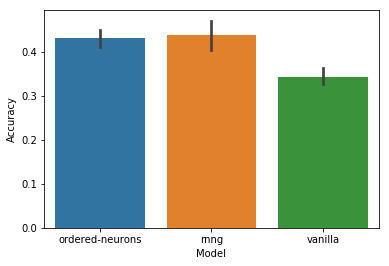

In [33]:
sns.barplot(data=results_df.reset_index(), x="model_name", y="correct")

plt.xlabel("Model")
plt.ylabel("Accuracy")

### Accuracy vs perplexity

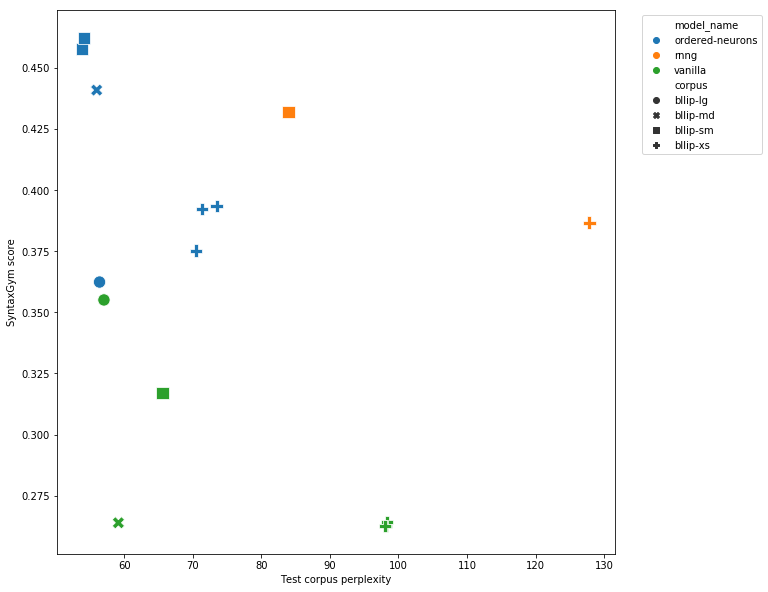

In [35]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=joined_data, x="test_ppl", y="correct",
                hue="model_name", style="corpus", s=150,
                hue_order=model_order)
plt.xlabel("Test corpus perplexity")
plt.ylabel("SyntaxGym score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

(0, 1)

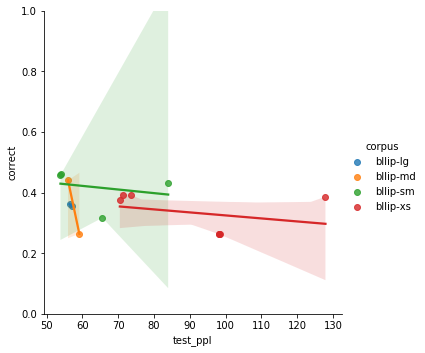

In [36]:
g = sns.lmplot(data=joined_data, x="test_ppl", y="correct",
               hue="corpus", truncate=True)
g.ax.set_ylim((0, 1))

(0, 1)

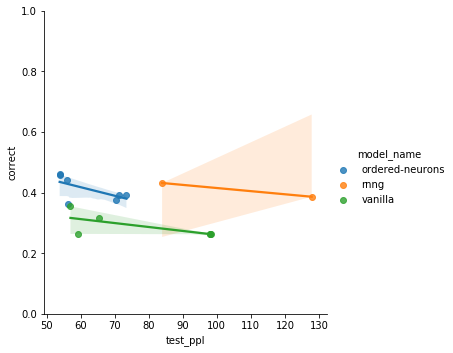

In [48]:
g = sns.lmplot(data=joined_data, x="test_ppl", y="correct",
               hue="model_name", truncate=True)
g.ax.set_ylim((0, 1))

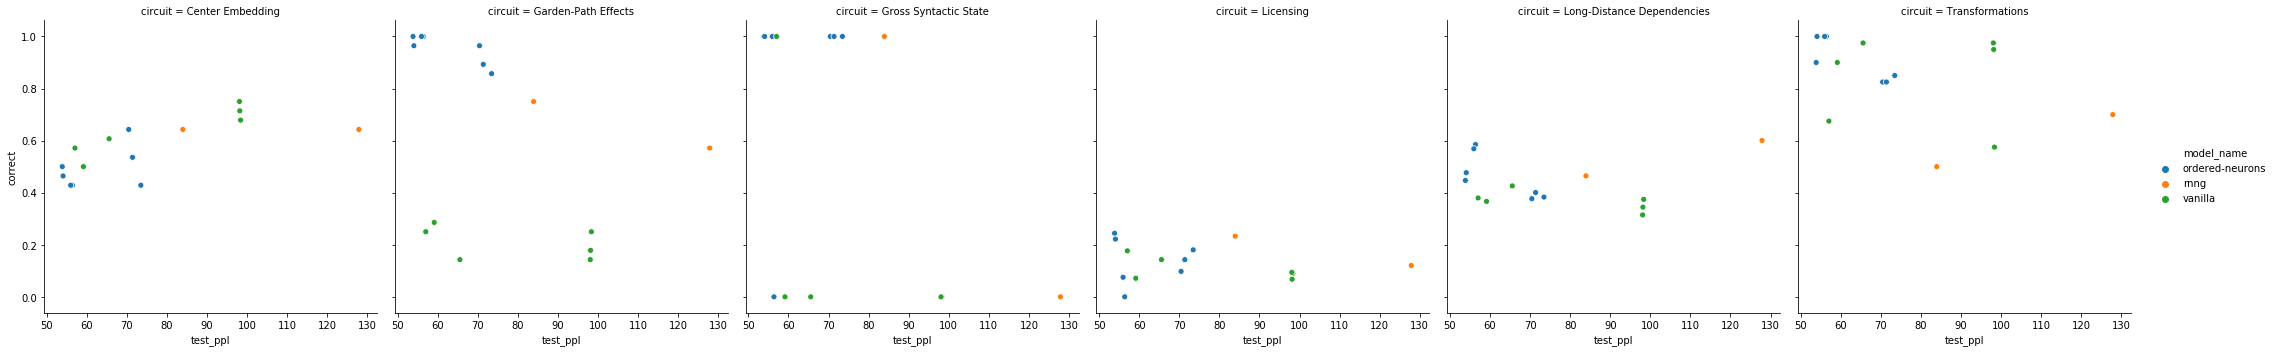

In [37]:
g = sns.FacetGrid(data=joined_data_circuits, col="circuit", height=5)
g.map(sns.scatterplot, "test_ppl", "correct", "model_name",
      hue_order=model_order)
g.add_legend()

In [38]:
joined_data_circuits.groupby(["model_name", "corpus", "circuit"]).correct.mean()

model_name       corpus    circuit                   
ordered-neurons  bllip-lg  Center Embedding              0.428571
                           Garden-Path Effects           1.000000
                           Gross Syntactic State         0.000000
                           Licensing                     0.000000
                           Long-Distance Dependencies    0.584900
                           Transformations               1.000000
                 bllip-md  Center Embedding              0.428571
                           Garden-Path Effects           1.000000
                           Gross Syntactic State         1.000000
                           Licensing                     0.075188
                           Long-Distance Dependencies    0.568609
                           Transformations               1.000000
                 bllip-sm  Center Embedding              0.482143
                           Garden-Path Effects           0.982143
                      

### Item-level prediction correlations across models

In [39]:
item_predictions = results_df.set_index(["suite", "item"]).sort_index().groupby(["model_name", "corpus", "seed"]).correct.apply(np.array)
model_correlations = []
for k1, k2 in itertools.combinations(list(item_predictions.index), 2):
    model_correlations.append(("_".join(map(str, k1)), *k1, "_".join(map(str, k2)), *k2, stats.spearmanr(item_predictions.loc[k1], item_predictions.loc[k2])[0]))

corr_df = pd.DataFrame(model_correlations, columns=["key_1", "model_1", "corpus_1", "seed_1", "key_2", "model_2", "corpus_2", "seed_2", "corr"])

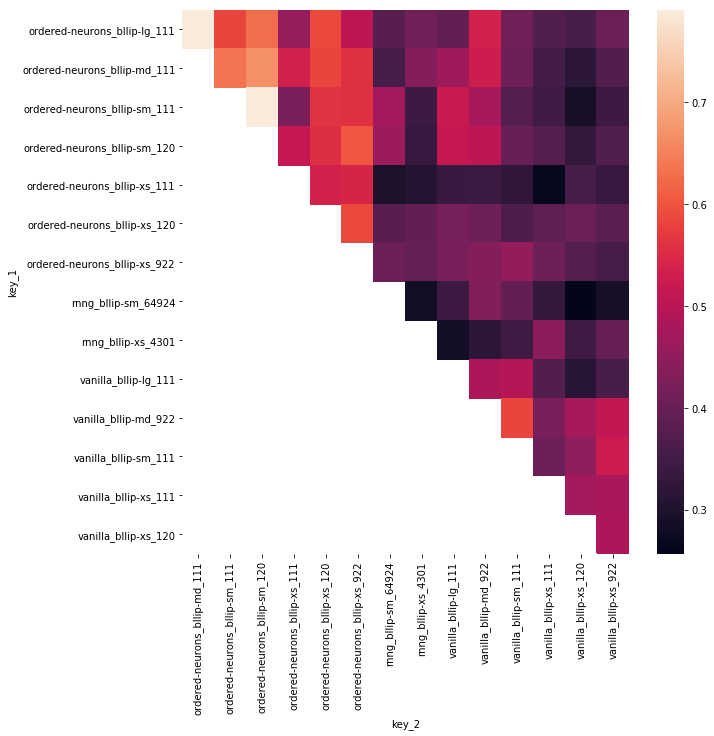

In [40]:
plt.subplots(figsize=(10, 10))
sns.heatmap(data=corr_df.pivot("key_1", "key_2", "corr"))

### Variance in accuracy vs variance in perplexity

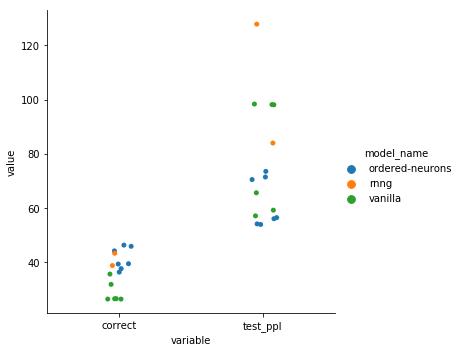

In [41]:
catplot_ticks = ["correct", "test_ppl"]
catplot_data = joined_data.copy()
catplot_data["correct"] *= 100
catplot_data = catplot_data.melt(id_vars=set(catplot_data.columns) - set(catplot_ticks))
catplot_data["corpus_size"] = catplot_data.corpus.map(corpus_to_size)

g = sns.catplot(data=catplot_data,
                x="variable", y="value", hue="model_name")

### Circuit–circuit correlations

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,0.98,'Circuit--circuit correlations')

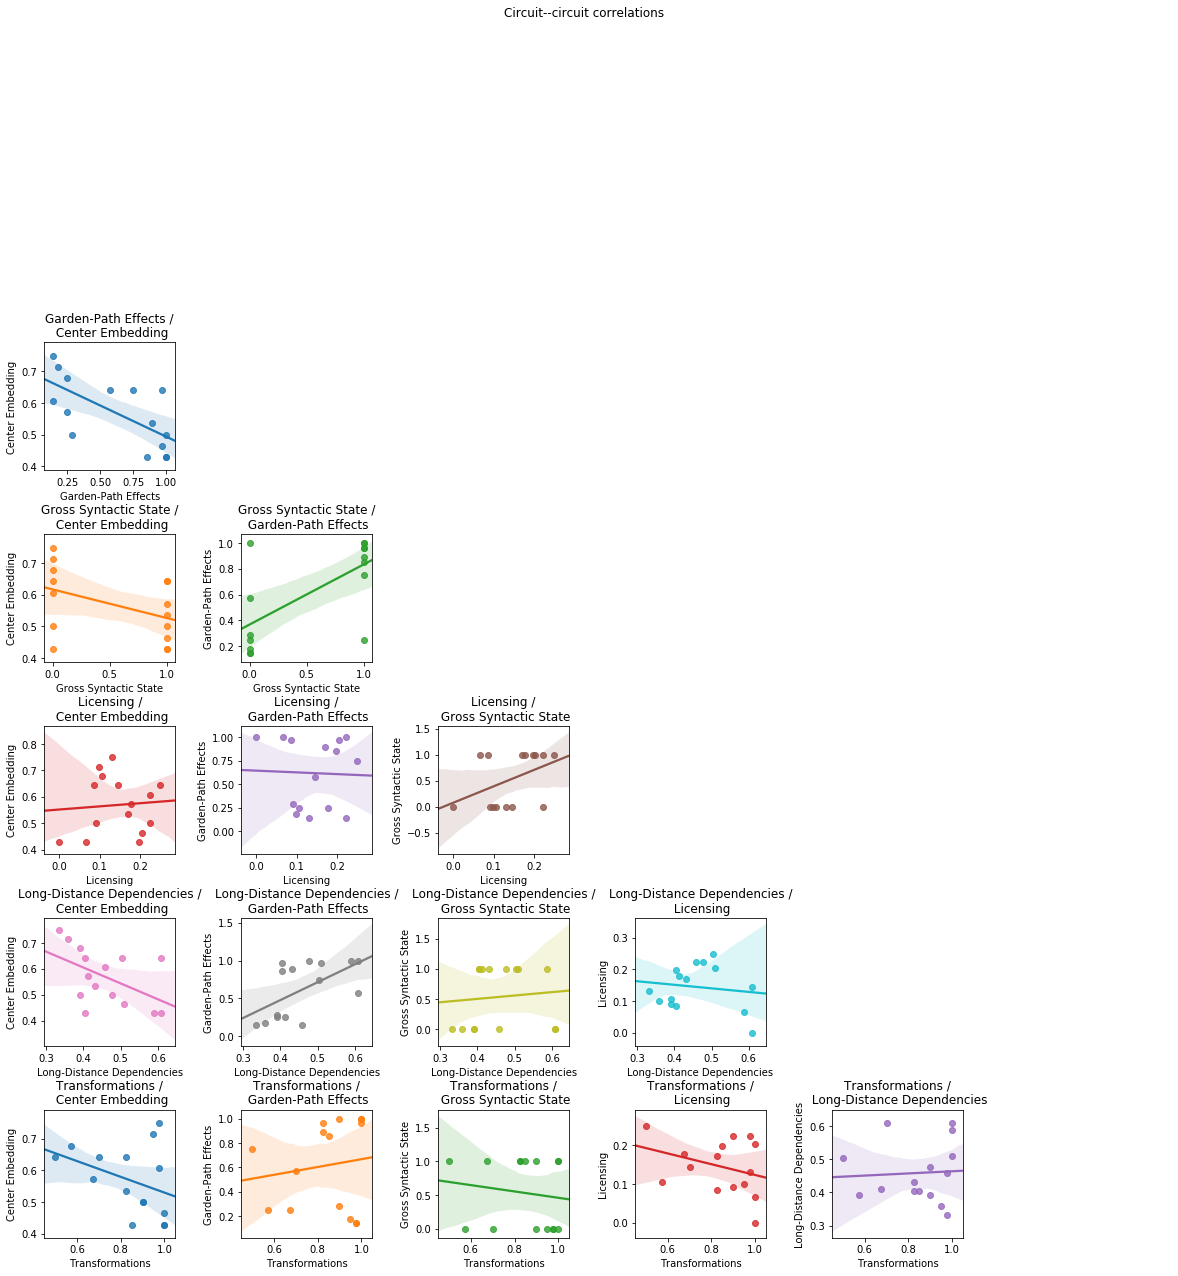

In [42]:
f, axs = plt.subplots(len(circuit_order), len(circuit_order), figsize=(20, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for c1, row in zip(circuit_order, axs):
    for c2, ax in zip(circuit_order, row):
        if c1 <= c2:
            ax.axis("off")
            continue
            
        xs = results_df[results_df.circuit == c1].groupby(["model_name", "corpus", "seed"]).correct.agg({c1: "mean"})
        ys = results_df[results_df.circuit == c2].groupby(["model_name", "corpus", "seed"]).correct.agg({c2: "mean"})
        df = pd.concat([xs, ys], axis=1)
        ax.set_title("%s /\n %s" % (c1, c2))
        sns.regplot(data=df, x=c1, y=c2, ax=ax)
        
plt.suptitle("Circuit--circuit correlations")

### Stability to modification

Text(0.5,1,'Stability to modification')

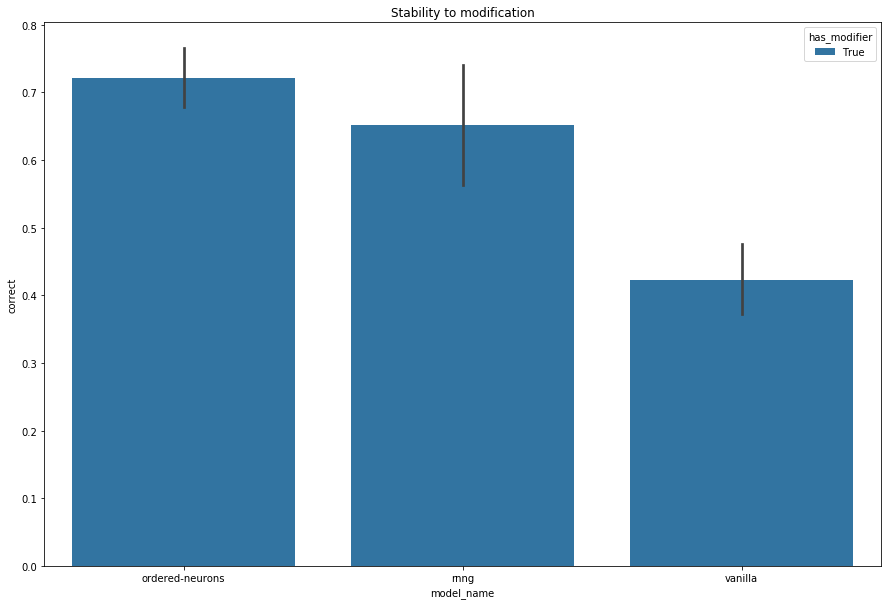

In [43]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=results_df_mod, x="model_name", y="correct", hue="has_modifier")
plt.title("Stability to modification")

Text(0.5,1,'Stability to modification')

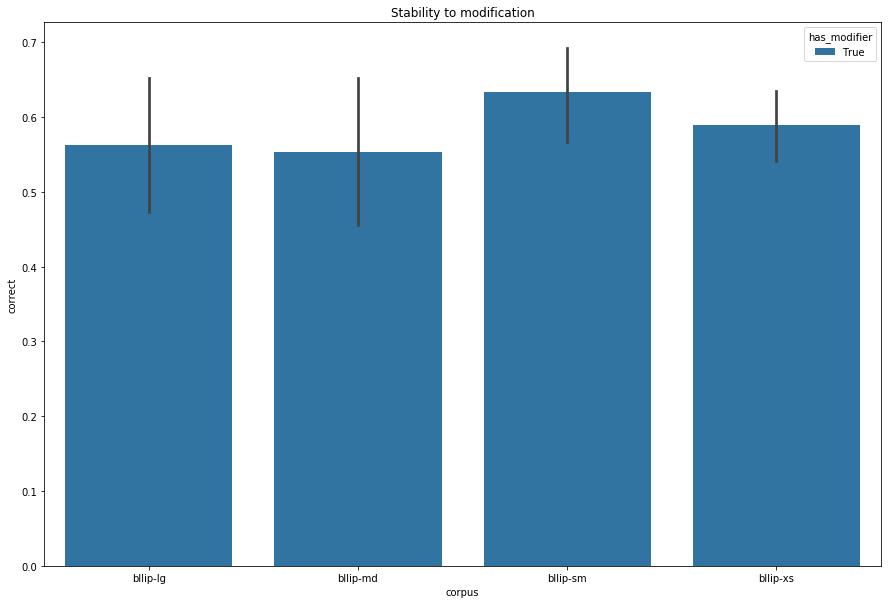

In [44]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=results_df_mod, x="corpus", y="correct", hue="has_modifier")
plt.title("Stability to modification")

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


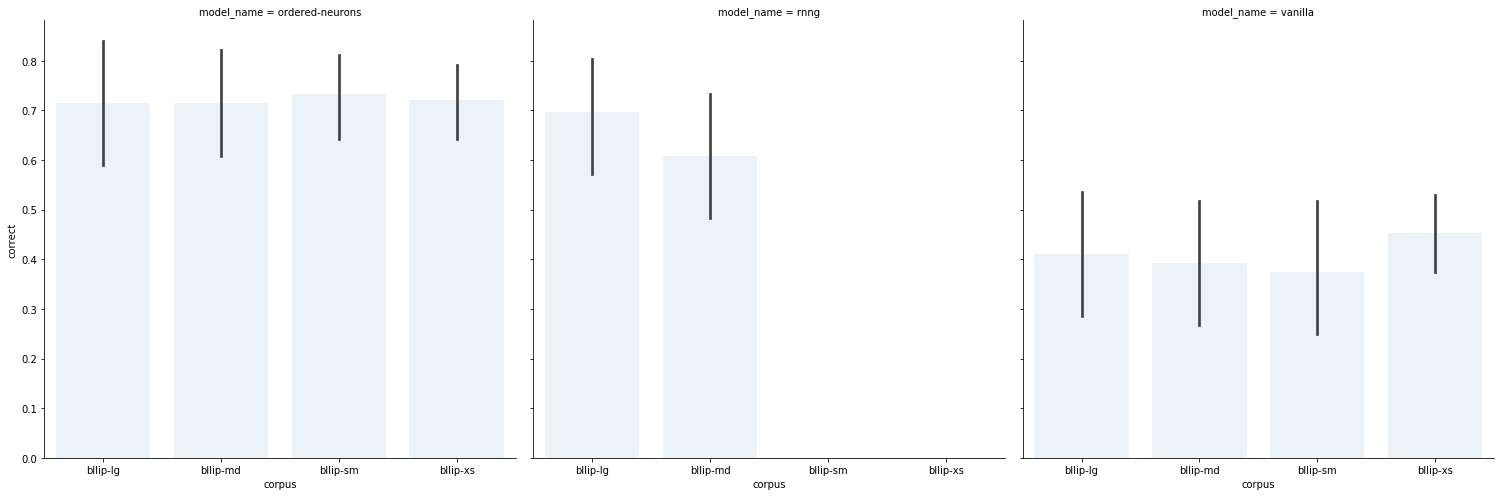

In [45]:
g = sns.FacetGrid(data=results_df_mod, col="model_name", height=7)
g.map(sns.barplot, "corpus", "correct", "has_modifier")

In [46]:
avg_mod_results = results_df_mod.groupby(["model_name", "test_suite_base", "has_modifier"]).correct.agg({"correct": "mean"}).sort_index()
avg_mod_diffs = avg_mod_results.xs(True, level="has_modifier") - avg_mod_results.xs(False, level="has_modifier")

plt.subplots(figsize=(15, 10))
sns.boxplot(data=avg_mod_diffs.reset_index(), x="model_name", y="correct")
plt.title("Change in accuracy due to modification")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


KeyError: False